In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import seaborn as sns
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from scipy import stats

# Extraccion de datos

In [11]:
def extract_num(string):
    if isinstance(string, str):
        return float(string.split('(')[1].split(')')[0])
    elif isinstance(string, float):
        return string
    else:
        return None

#calcula el indice de jaccard en al region semilla
def calculate_jaccard (Interaction):
    lst = Interaction.split('&')
    puntos = 0
    seedpair = 0
    #parentesis_cerrados = 0
    
    for cadena in lst[0]:
        puntos += cadena.count('.')
        seedpair += cadena.count('(')
        #parentesis_cerrados += cadena.count(')')
        
    j = (seedpair) / (puntos + seedpair)
    return j



def clean_df(df):
    
    lst_conserved =[]; lst_miRNA = []; lst_prediction = []
    for i in range(len(df[0])-2):
        header = df[0][i]; miRNA = df[0][i+1]; prediction = df[0][i+2]
        
        if prediction.startswith('.') or prediction.startswith('('):
            bool_prediction = True
        else:
            bool_prediction = False
            
        if header.startswith('>') and miRNA.startswith('>hsa') and bool_prediction == True:
            lst_conserved.append(header); lst_miRNA.append(miRNA); lst_prediction.append(prediction)

    df = pd.DataFrame({
        'UTR_region': lst_conserved,
        'miRNA':lst_miRNA, 
        'Prediction':lst_prediction})

    df['Prediction'] = df['Prediction'].str.replace('( ', '(', regex=False)
    df['Prediction'] = df['Prediction'].str.replace('< ', '<', regex=False)
    df_e = df['Prediction'].apply(lambda x: x.split()).apply(pd.Series)
    df = pd.concat([df, df_e], axis = 1)
    
    df.drop([2], axis=1, inplace = True)
    df.columns = ['UTR_region', 'miRNA', 'Prediction', 'Interaction', 'InteractionRegionUTR', 
              'InteractionRegionmiRNA', 'DuplexEnergy', 'InteractionResidues', 'MinimumEnergy']
    
    df['DuplexEnergy'] = list(map(extract_num, df['DuplexEnergy']))
    df = df.sort_values(by=['DuplexEnergy'])

    df['Jaccard'] = list(map(calculate_jaccard, df['Interaction']))
    
    UTR3 = 29674
    UTR5 = 265

    lst_type = []
    for i in df['UTR_region']: 
        start,end = i.split(':')[1].split('-')
        if int(end) <= UTR5:
            lst_type.append("5'UTR")
        else:
            lst_type.append("3'UTR")
    df['Region'] = lst_type

    lst = []
    for i in df['UTR_region']:
        lst.append(i.split(':')[0].split('>')[1])
    df['Variant'] = lst
    return df

In [12]:
dfv = pd.read_csv('../../Data/Estratos/miRNA_predict/conserved_SinFold_regions_UTR_variants_predicted_miRNA.txt', sep = '\t', header = None)
dfv = clean_df(dfv)
dfv

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
59085,>20A:29-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"61,85","1,25",-34.5,"i:84,j:1",<-34.60>,0.840000,5'UTR,20A
292706,>20G:34-202,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"56,80","1,25",-34.5,"i:79,j:1",<-34.60>,0.840000,5'UTR,20G
5995,>19A:29-218,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"61,85","1,25",-34.5,"i:84,j:1",<-34.60>,0.840000,5'UTR,19A
709470,>21G:67-185,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"23,47","1,25",-34.5,"i:46,j:1",<-34.60>,0.840000,5'UTR,21G
828944,>21J:26-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.840000,5'UTR,21J
...,...,...,...,...,...,...,...,...,...,...,...,...
1447772,>recombinant:1-4,>hsa-miR-1249-3p,".(.&.) 2,4 : 21,22 (4.10) i:3,j:22 <3.60>",.(.&.),"2,4","21,22",4.1,"i:3,j:22",<3.60>,0.333333,5'UTR,recombinant
1413455,>23F:200-203,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:3,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:3,j:21",<3.80>,0.333333,5'UTR,23F
330311,>20H:17-20,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:2,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:2,j:21",<3.80>,0.333333,5'UTR,20H
1119,>19A:17-20,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:2,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:2,j:21",<3.80>,0.333333,5'UTR,19A


In [13]:
dft = pd.read_csv('../../Data/Estratos/miRNA_predict/conserved_regions_UTR_time_predicted_miRNA.txt', sep = '\t', header = None)
dft = clean_df(dft)
dft

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
329976,">(2022-11-01,2023-01-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2022-11-01,2023-01-01]"
186600,">(2021-05-01,2022-01-01]:26-173",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.840000,5'UTR,"(2021-05-01,2022-01-01]"
290152,">(2022-06-01,2022-11-01]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2022-06-01,2022-11-01]"
422889,">(2023-07-01,2023-09-06]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2023-07-01,2023-09-06]"
377753,">(2023-01-01,2023-07-01]:45-192",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2023-01-01,2023-07-01]"
...,...,...,...,...,...,...,...,...,...,...,...,...
363952,">(2022-11-01,2023-01-01]:29890-29903",>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:13,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:13,j:22",<3.60>,0.333333,3'UTR,"(2022-11-01,2023-01-01]"
365617,">(2022-11-01,2023-01-01]:29890-29903",>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:13,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:13,j:20",<3.60>,0.333333,3'UTR,"(2022-11-01,2023-01-01]"
411744,">(2023-01-01,2023-07-01]:29871-29903",>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:32,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:32,j:22",<3.60>,0.333333,3'UTR,"(2023-01-01,2023-07-01]"
63539,">(2020-09-01,2021-01-01]:16-15",>hsa-miR-6891-3p,".(&.). 3,4 : 5,7 (4.00) i:4,j:6 <3.70>",.(&.).,"3,4","5,7",4.0,"i:4,j:6",<3.70>,0.500000,5'UTR,"(2020-09-01,2021-01-01]"


In [15]:
dfgt = pd.read_csv('../../Data/Estratos/miRNA_predict/conserved_regions_UTR_ConstantClusters_predicted_miRNA.txt', sep = '\t', header = None)
dfgt = clean_df(dfgt)
dfgt

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
11307,>Gst1:67-209,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"23,47","1,25",-34.5,"i:46,j:1",<-34.60>,0.840000,5'UTR,Gst1
12816,>Gst1:67-209,>hsa-miR-6762-5p,.(((((((((((..(((((((.&)))))))...))))))))))). ...,.(((((((((((..(((((((.&)))))))...))))))))))).,"118,139","1,22",-29.1,"i:138,j:1",<-29.20>,0.818182,5'UTR,Gst1
12429,>Gst1:67-209,>hsa-miR-4758-5p,.((((.((((.(((((.(..........(((((((.&))))))))....,.((((.((((.(((((.(..........(((((((.&))))))))....,"23,58","1,23",-28.3,"i:57,j:1",<-26.90>,0.583333,5'UTR,Gst1
11485,>Gst1:67-209,>hsa-miR-1226-5p,.(((((.(..(.(((((((((.......(((((.&)))))))))))...,.(((((.(..(.(((((((((.......(((((.&)))))))))))...,"25,58","1,25",-27.9,"i:57,j:1",<-27.40>,0.617647,5'UTR,Gst1
12482,>Gst1:67-209,>hsa-miR-4787-5p,.((((.((((((((((..((((.&)))))))))))))).)))). ...,.((((.((((((((((..((((.&)))))))))))))).)))).,"19,41","1,20",-27.9,"i:40,j:1",<-27.60>,0.782609,5'UTR,Gst1
...,...,...,...,...,...,...,...,...,...,...,...,...
39192,>Gst1:29871-29903,>hsa-miR-5703,".(.&.) 1,3 : 17,18 (4.00) i:32,j:18 <3.60>",.(.&.),"1,3","17,18",4.0,"i:32,j:18",<3.60>,0.333333,3'UTR,Gst1
98388,>Gst2:29890-29903,>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:13,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:13,j:22",<3.60>,0.333333,3'UTR,Gst2
38996,>Gst1:29871-29903,>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:32,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:32,j:20",<3.60>,0.333333,3'UTR,Gst1
100457,>Gst2:29890-29903,>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:13,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:13,j:21",<3.60>,0.333333,3'UTR,Gst2


In [16]:
dfs = pd.read_csv('../../Data/Estratos/miRNA_predict/conserved_regions_UTR_spectral_predicted_miRNA.txt', sep = '\t', header = None)
dfs = clean_df(dfs)
dfs

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
72350,>G2:67-125,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"23,47","1,25",-34.5,"i:46,j:1",<-34.60>,0.840000,5'UTR,G2
73472,>G2:67-125,>hsa-miR-4758-5p,.((((.((((.(((((.(..........(((((((.&))))))))....,.((((.((((.(((((.(..........(((((((.&))))))))....,"23,58","1,23",-28.3,"i:57,j:1",<-26.90>,0.583333,5'UTR,G2
73525,>G2:67-125,>hsa-miR-4787-5p,.((((.((((((((((..((((.&)))))))))))))).)))). ...,.((((.((((((((((..((((.&)))))))))))))).)))).,"19,41","1,20",-27.9,"i:40,j:1",<-27.60>,0.782609,5'UTR,G2
72528,>G2:67-125,>hsa-miR-1226-5p,.(((((.(..(.(((((((((.......(((((.&)))))))))))...,.(((((.(..(.(((((((((.......(((((.&)))))))))))...,"25,58","1,25",-27.9,"i:57,j:1",<-27.40>,0.617647,5'UTR,G2
72343,>G2:67-125,>hsa-miR-33b-3p,.(((((((((((.((.(((((.&.))))))).)))).))))))). ...,.(((((((((((.((.(((((.&.))))))).)))).))))))).,"34,55","1,22",-27.9,"i:54,j:2",<-27.90>,0.818182,5'UTR,G2
...,...,...,...,...,...,...,...,...,...,...,...,...
60633,>G1:29891-29894,>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:3,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:3,j:21",<3.60>,0.333333,3'UTR,G1
55923,>G1:29883-29886,>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:3,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:3,j:22",<3.60>,0.333333,3'UTR,G1
60229,>G1:29891-29894,>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:3,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:3,j:20",<3.60>,0.333333,3'UTR,G1
108007,>G2:29873-29903,>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:30,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:30,j:20",<3.60>,0.333333,3'UTR,G2


In [17]:
dfsp = pd.read_csv('../../Data/Estratos/miRNA_predict/conserved_regions_UTR_spectrum_predicted_miRNA.txt', sep = '\t', header = None)
dfsp = clean_df(dfsp)
dfsp

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
53787,>Gs2:45-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,Gs2
157352,>Gs4:45-209,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,Gs4
5995,>Gs1:45-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,Gs1
93625,>Gs3:45-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,Gs3
158861,>Gs4:45-209,>hsa-miR-6762-5p,.(((((((((((..(((((((.&)))))))...))))))))))). ...,.(((((((((((..(((((((.&)))))))...))))))))))).,"140,161","1,22",-29.1,"i:160,j:1",<-29.20>,0.818182,5'UTR,Gs4
...,...,...,...,...,...,...,...,...,...,...,...,...
196068,>Gs4:29873-29903,>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:30,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:30,j:21",<3.60>,0.333333,3'UTR,Gs4
45298,>Gs1:29882-29903,>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:21,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:21,j:22",<3.60>,0.333333,3'UTR,Gs1
195664,>Gs4:29873-29903,>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:30,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:30,j:20",<3.60>,0.333333,3'UTR,Gs4
145216,>Gs3:29871-29903,>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:32,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:32,j:20",<3.60>,0.333333,3'UTR,Gs3


In [18]:
dft.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Time_SinFiltrar.tsv', sep = '\t', index = False)
dfv.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conservedSinEstructuraSecundaria_Variants_SinFiltrar.tsv', sep = '\t', index = False)

dfgt.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_ConstantClusters_SinFiltrar.tsv', sep = '\t', index = False)
dfs.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Spectral_SinFiltrar.tsv', sep = '\t', index = False)
dfsp.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Spectrum_SinFiltrar.tsv', sep = '\t', index = False)

# Inspeccion

In [19]:
dft = pd.read_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Time_SinFiltrar.tsv', sep = '\t')
dfv = pd.read_csv('../../Data/Estratos/miRNA_predict/miRNA_conservedSinEstructuraSecundaria_Variants_SinFiltrar.tsv', sep = '\t')
dfgt = pd.read_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_ConstantClusters_SinFiltrar.tsv', sep = '\t')
dfs = pd.read_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Spectral_SinFiltrar.tsv', sep = '\t')
dfsp = pd.read_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Spectrum_SinFiltrar.tsv', sep = '\t')

/home/ferambriz/.local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'markers', 'style'
  cset = contour_func(
/home/ferambriz/.local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'markers', 'style'
  cset = contour_func(
/home/ferambriz/.local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'markers', 'style'
  cset = contour_func(


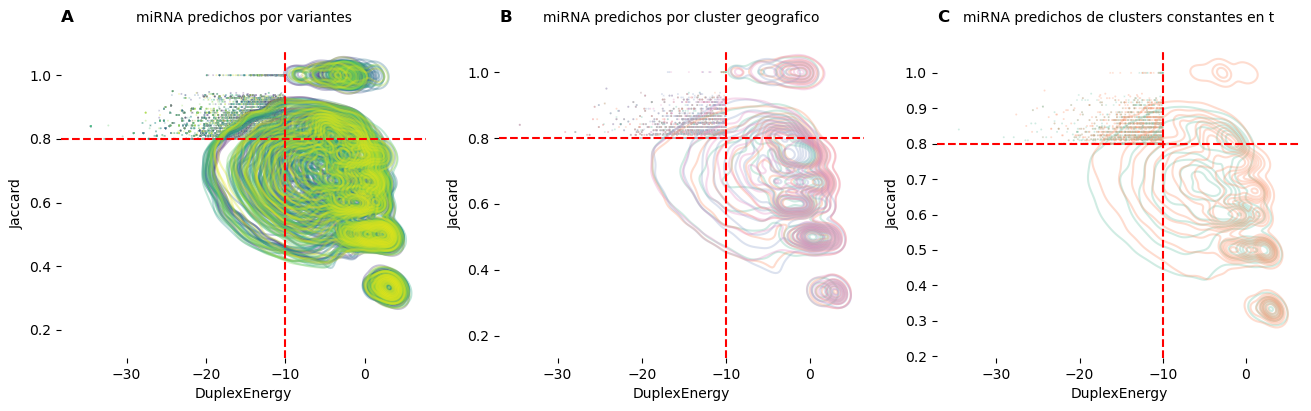

In [20]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 3)

markers = {"5'UTR": 'o', "3'UTR": 'X'}

#===================================== First plot on the top =============================
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=dfv, x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                    markers=markers, style = 'Region', alpha = 0.3, ax=ax1, legend = False, palette = 'viridis')
sns.scatterplot(data=dfv[(dfv['DuplexEnergy']<=-10) & (dfv['Jaccard'] >=0.8)], x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                markers=markers, style = 'Region', alpha = 0.3, ax=ax1, legend = False, palette = 'viridis', s = 2)


plt.axvline(x=-10, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')


#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("A", fontweight="bold", loc = 'left')
ax1.set_title('miRNA predichos por variantes', fontsize=10, pad=20)



ax2 = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=dfsp, x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                    markers=markers, style = 'Region', alpha = 0.3, ax=ax2, legend = False, palette = 'Set2')
sns.scatterplot(data=dfsp[(dfsp['DuplexEnergy']<=-10) & (dfsp['Jaccard'] >=0.8)], x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                markers=markers, style = 'Region', alpha = 0.3, ax=ax2, legend = False, palette = 'Set2', s = 2)


plt.axvline(x=-10, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')


#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("B", fontweight="bold", loc = 'left')
ax2.set_title('miRNA predichos por cluster geografico', fontsize=10, pad=20)




ax3 = fig.add_subplot(gs[0, 2])
sns.kdeplot(data=dfgt, x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                    markers=markers, style = 'Region', alpha = 0.3, ax=ax3, legend = False, palette = 'Set2')
sns.scatterplot(data=dfgt[(dfgt['DuplexEnergy']<=-10) & (dfgt['Jaccard'] >=0.8)], x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                markers=markers, style = 'Region', alpha = 0.3, ax=ax3, legend = False, palette = 'Set2', s = 2)


plt.axvline(x=-10, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')


#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("C", fontweight="bold", loc = 'left')
ax3.set_title('miRNA predichos de clusters constantes en t', fontsize=10, pad=20)


#delete box
sns.despine(left=True, bottom=True)
plt.savefig('../../Plots/miRNAPredichos.pdf')

# Estadisticas

In [ ]:
def extract_variant(string):
    return string.split(':')[0].split('>')[1]
    
dfv['Variant'] = list(map(extract_variant, dfv['UTR_region']))
dfv

In [ ]:
dfvi = pd.DataFrame(dfv[['Variant', 'Region']].value_counts()).reset_index()
dfvi.groupby(by='Region').agg(['mean', 'std'])

In [13]:
def extract_region(string):
    return string.split(':')[1]
dfv['RegionMap'] = list(map(extract_region, dfv['UTR_region']))

dfvr = pd.DataFrame(dfv[['RegionMap']].value_counts()).reset_index()
dfvr

,RegionMap,0
0,29696-29695,100928
1,256-255,100928
2,228-234,95616
3,224-223,74368
4,29871-29903,58102
...,...,...
259,29871-29902,2641
260,29871-29898,2641
261,29871-29891,2641
262,29871-29884,2641


In [14]:
dft['Variant'] = list(map(extract_variant, dft['UTR_region']))
dft

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
0,">(2022-11-01,2023-01-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2022-11-01,2023-01-01]"
1,">(2021-05-01,2022-01-01]:26-173",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.840000,5'UTR,"(2021-05-01,2022-01-01]"
2,">(2022-06-01,2022-11-01]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2022-06-01,2022-11-01]"
3,">(2023-07-01,2023-09-06]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2023-07-01,2023-09-06]"
4,">(2023-01-01,2023-07-01]:45-192",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.840000,5'UTR,"(2023-01-01,2023-07-01]"
...,...,...,...,...,...,...,...,...,...,...,...,...
464681,">(2022-11-01,2023-01-01]:29890-29903",>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:13,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:13,j:22",<3.60>,0.500000,3'UTR,"(2022-11-01,2023-01-01]"
464682,">(2022-11-01,2023-01-01]:29890-29903",>hsa-miR-4768-3p,".(.&.) 1,3 : 19,20 (4.00) i:13,j:20 <3.60>",.(.&.),"1,3","19,20",4.0,"i:13,j:20",<3.60>,0.500000,3'UTR,"(2022-11-01,2023-01-01]"
464683,">(2023-01-01,2023-07-01]:29871-29903",>hsa-miR-214-3p,".(.&.) 1,3 : 21,22 (4.00) i:32,j:22 <3.60>",.(.&.),"1,3","21,22",4.0,"i:32,j:22",<3.60>,0.500000,3'UTR,"(2023-01-01,2023-07-01]"
464684,">(2020-09-01,2021-01-01]:16-15",>hsa-miR-6891-3p,".(&.). 3,4 : 5,7 (4.00) i:4,j:6 <3.70>",.(&.).,"3,4","5,7",4.0,"i:4,j:6",<3.70>,0.333333,5'UTR,"(2020-09-01,2021-01-01]"


In [15]:
pd.DataFrame(dft[['Variant', 'Region']].value_counts()).agg(['mean', 'std'])

,0
mean,23234.300000
std,8693.060161


In [16]:
dfti = pd.DataFrame(dft[['Variant', 'Region']].value_counts()).reset_index()
dfti.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_11146/2832634115.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dfti.groupby(by='Region').agg(['mean', 'std'])


0             
           mean          std
Region                      
3'UTR   28939.0  7660.626113
5'UTR   17529.6  5341.429588

In [17]:
dft['RegionMap'] = list(map(extract_region, dft['UTR_region']))

dfvt = pd.DataFrame(dft[['RegionMap']].value_counts()).reset_index()
dfvt

,RegionMap,0
0,29696-29695,26560
1,256-255,26560
2,29824-29823,21248
3,29776-29775,18592
4,29701-29705,15930
...,...,...
78,29745-29750,2656
79,29711-29717,2655
80,29896-29895,2641
81,29888-29887,2641


# Filtro

In [21]:
df_vf = dfv[(dfv['DuplexEnergy']<=-10) & (dfv['Jaccard'] >=0.8)]
df_tf = dft[(dft['DuplexEnergy']<=-10) & (dft['Jaccard'] >=0.8)]
dfgtf = dfgt[(dfgt['DuplexEnergy']<=-10) & (dfgt['Jaccard'] >=0.8)]
dfsf = dfs[(dfs['DuplexEnergy']<=-10) & (dfs['Jaccard'] >=0.8)]
dfspf = dfsp[(dfsp['DuplexEnergy']<=-10) & (dfsp['Jaccard'] >=0.8)]

In [22]:
lst = []
for i in df_tf['miRNA']:
    lst.append(i.split('>')[1])
df_tf['miRNA_lite'] = lst

lst = []
for i in df_vf['miRNA']:
    lst.append(i.split('>')[1])
df_vf['miRNA_lite'] = lst

lst = []
for i in dfgtf['miRNA']:
    lst.append(i.split('>')[1])
dfgtf['miRNA_lite'] = lst

lst = []
for i in dfsf['miRNA']:
    lst.append(i.split('>')[1])
dfsf['miRNA_lite'] = lst

lst = []
for i in dfspf['miRNA']:
    lst.append(i.split('>')[1])
dfspf['miRNA_lite'] = lst

/tmp/ipykernel_4421/1249333052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf['miRNA_lite'] = lst
/tmp/ipykernel_4421/1249333052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf['miRNA_lite'] = lst
/tmp/ipykernel_4421/1249333052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [23]:
df_vf.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conservedSinEstructuraSecundaria_Variants_Filtrado.tsv', sep = '\t', index = False)
df_tf.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Time_Filtrado.tsv', sep = '\t', index = False)
dfgtf.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_ConstantClusters_Filtrado.tsv', sep = '\t', index = False)
dfsf.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Spectral_Filtrado.tsv', sep = '\t', index = False)
dfspf.to_csv('../../Data/Estratos/miRNA_predict/miRNA_conserved_Spectrum_Filtrado.tsv', sep = '\t', index = False)

# Inspeccion

In [24]:
dfvif = pd.DataFrame(df_vf[['Variant', 'Region']].value_counts()).reset_index()
dfvif.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_4421/1984861854.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dfvif.groupby(by='Region').agg(['mean', 'std'])


0            
              mean         std
Region                        
3'UTR   485.789474  137.368346
5'UTR   698.789474  178.528392

In [131]:
len(df_tf)

11725

In [130]:
dftif = pd.DataFrame(df_tf[['Variant', 'Region']].value_counts()).reset_index()
dftif.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_12189/1646039635.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dftif.groupby(by='Region').agg(['mean', 'std'])


0            
              mean         std
Region                        
3'UTR   379.818182   80.537964
5'UTR   686.090909  151.389864

In [25]:
bxv = pd.DataFrame(df_vf[['Variant', 'Region']].value_counts()).reset_index()
bxt = pd.DataFrame(df_tf[['Variant', 'Region']].value_counts()).reset_index()
bxgt = pd.DataFrame(dfgtf[['Variant', 'Region']].value_counts()).reset_index()
bxs = pd.DataFrame(dfsf[['Variant', 'Region']].value_counts()).reset_index()
bxsp = pd.DataFrame(dfspf[['Variant', 'Region']].value_counts()).reset_index()

In [104]:
def estadistico(df):
    df5 = df[df['Region'] == "5'UTR"]
    df3 = df[df['Region'] == "3'UTR"]


    shapiro_test5 = stats.shapiro(df5[0])    
    shapiro_test3 = stats.shapiro(df3[0])
    print(f'shapiro wilk{shapiro_test5.pvalue, shapiro_test3.pvalue}')
    if shapiro_test5.pvalue > 0.05 and shapiro_test3.pvalue > 0.05:
        print('t-student')
        test = stats.ttest_ind(df5[0], df3[0])
    else:
        print('mannwhitneu')
        test = stats.mannwhitneyu(df5[0], df3[0])
    return test

In [105]:
estadistico(bxt)

shapiro wilk(0.4455223083496094, 0.9768904447555542)
t-student


TtestResult(statistic=5.923688280836523, pvalue=8.56746278964184e-06, df=20.0)

In [106]:
estadistico(bxv)

shapiro wilk(0.3442733585834503, 0.019390715286135674)
mannwhitneu


MannwhitneyuResult(statistic=1429.0, pvalue=2.4547958115467475e-11)

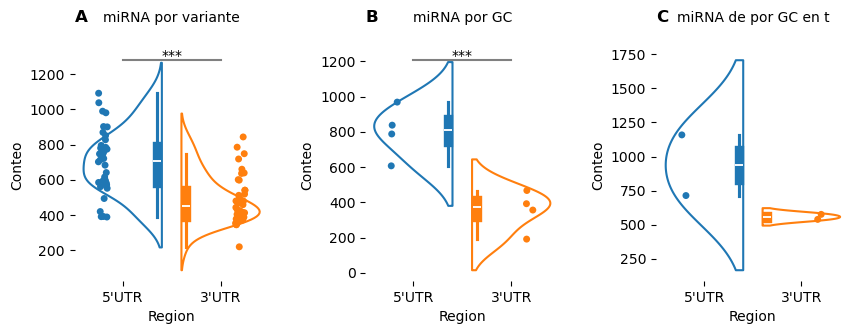

In [26]:
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 3)

#===================================== First plot on the top =============================
#ax1 = fig.add_subplot(gs[0, 0])
#sns.histplot(data=df_vf, x="Variant", kde=True, hue="Region", alpha =0.2, ax=ax1)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 8)
#===================================== Second plot on the top =============================
#ax2 = fig.add_subplot(gs[0, 1])
#sns.histplot(data=df_tf.sort_values(by=['Variant']), x="Variant", kde=True, hue="Region", alpha =0.2, ax=ax2)
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=70, fontsize = 7)
#===================================== Third plot on the top =============================
ax3 = fig.add_subplot(gs[0, 0])
sns.violinplot(data=bxv, x="Region", y=0, hue="Region", fill=False, ax = ax3, split = True)
sns.stripplot(data=bxv, x="Region", y=0, hue="Region", dodge=True, jitter=True, ax=ax3)

# Barra de significancia
y_max = max(bxv[0]) + 100
y_min = min(bxv[0]) + 100
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("A", fontweight="bold", loc = 'left')
ax3.set_title('miRNA por variante', fontsize=10, pad=20)
#===================================== Four plot on the top =============================
#ax4 = fig.add_subplot(gs[0, 1])
#sns.violinplot(data=bxt, x="Region", y=0, hue="Region", fill=False, ax = ax4, split = True)
#sns.stripplot(data=bxt, x="Region", y=0, hue="Region", dodge=True, jitter=True, ax=ax4)

# Barra de significancia
#y_max = max(bxt[0]) + 160
#y_min = min(bxt[0]) + 160
#y = y_max + (y_max - y_min) * 0.1  
#plt.plot([0, 1], [y, y], color='gray') 
#plt.text(0.5, y, "***", ha='center') 

#plt.ylabel('Conteo')

#plt.title("B", fontweight="bold", loc = 'left')
#ax4.set_title('miRNA por cluster', fontsize=10, pad=20)

#===================================== Four plot on the top =============================

ax5 = fig.add_subplot(gs[0, 1])
sns.violinplot(data=bxsp, x="Region", y=0, hue="Region", fill=False, ax = ax5, split = True)
sns.stripplot(data=bxsp, x="Region", y=0, hue="Region", dodge=True, jitter=True, ax=ax5)

# Barra de significancia
y_max = max(bxsp[0]) + 160
y_min = min(bxsp[0]) + 160
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("B", fontweight="bold", loc = 'left')
ax5.set_title('miRNA por GC', fontsize=10, pad=20)

#===================================== Four plot on the top =============================
ax6 = fig.add_subplot(gs[0, 2])
sns.violinplot(data=bxgt, x="Region", y=0, hue="Region", fill=False, ax = ax6, split = True)
sns.stripplot(data=bxgt, x="Region", y=0, hue="Region", dodge=True, jitter=True, ax=ax6)

# Barra de significancia
#y_max = max(bxgt[0]) + 160
#y_min = min(bxgt[0]) + 160
#y = y_max + (y_max - y_min) * 0.1  
#plt.plot([0, 1], [y, y], color='gray') 
#plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("C", fontweight="bold", loc = 'left')
ax6.set_title('miRNA de por GC en t', fontsize=10, pad=20)


#delete box
sns.despine(left=True, bottom=True)
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.savefig('../../Plots/FilterSummary.pdf', bbox_inches='tight')